# Javier Blanco Cordero
Contact: javierblancordero@gmail.com
## causaLens - Code Test
27/06/2020

# 0. Helpers

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sys
import scipy.stats
from pandas.plotting import register_matplotlib_converters

from sklearn import linear_model
from statsmodels.tsa._stl import STL
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from statsmodels.graphics import tsaplots
from fbprophet import Prophet
import ephem

In [26]:
sns.set()
plt.rcParams['figure.figsize'] = (20, 5)
register_matplotlib_converters()

In [27]:
def plot_AC_and_PAC(series, lags):
    fig, (ax1,ax2) = plt.subplots(1, 2)
    
    tsaplots.plot_acf(series, ax=ax1, lags=lags, alpha=.05)
    ax1.set_title('AC '+series.name)
    
    tsaplots.plot_pacf(series, ax=ax2, lags=lags, alpha=.05)
    ax2.set_title('PAC ' +series.name)
    plt.show()

In [28]:
def plot_residuals_distribution(total_residuals, train_residuals, test_residuals, lags):
    plt.plot(train_residuals.index, train_residuals, color='blue', alpha=.75, label='train')
    plt.plot(test_residuals.index, test_residuals, color='red', alpha=.75, label='test')
    plt.title('Residuals evolution', size=15)
    plt.axvline(train_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
    plt.legend()
    plt.show()
    
    fig, (ax1,ax2) = plt.subplots(1, 2)
    tsaplots.plot_acf(train_residuals, ax=ax1, lags=lags, alpha=.05, label='train', color='blue')
    tsaplots.plot_acf(test_residuals, ax=ax1, lags=lags, alpha=.05, label='test', color='red')
    ax1.set_title('Residuals Autocorrelation')
    
    ax2.set_title('Residuals Distribution')
    sns.distplot(train_residuals, ax=ax2, label='train', color='blue')
    sns.distplot(test_residuals, ax=ax2, label='test', color='red')
    plt.axvline(0, color='black', linewidth=1)
    
    plt.legend()
    plt.show()

In [29]:
def progressBar(value, endvalue, bar_length=20):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length) - 1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write(
        "\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [30]:
def prophet_predict_by_chunks(df_to_forecast, model):
    """ 
    Prophet seems to struggle with big chunks of data. 
    Let's break it into smaller pieces.
    """
    index_df = pd.DatetimeIndex(df_to_forecast['ds'])
    forecast = pd.DataFrame()
    total_chunks = 0
    for i, year in enumerate(list(index_df.year.unique())):
        for j, month in enumerate(list(index_df[index_df.year==year].month.unique())):
            total_chunks += 1
    
    iteration = 0
    for year in list(index_df.year.unique()):
        for month in list(index_df[index_df.year==year].month.unique()):
            df_ij = df_to_forecast.loc[((index_df.year == year)&(index_df.month == month))]
            forecast = forecast.append(model.predict(df_ij))
            
            iteration += 1
            progressBar(iteration, total_chunks, bar_length=20)
    
    return forecast

# 1. Import data
### 1.1 Load data

In [36]:
main_df = pd.read_csv('Data/venezia_transformed.csv')

display(main_df.head())
main_df.info()

,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration,Venice_relative_subsidence,CSIRO_adj_sea_level,adj_level
0,1983-01-01 01:00:00,44.0,0.002394,0.983272,0.983233,6.125102e-23,0.000000,1.12,42.880000
1,1983-01-01 02:00:00,35.0,0.002395,0.983271,0.982423,6.125107e-23,0.000011,1.12,33.879989
2,1983-01-01 03:00:00,23.0,0.002396,0.983271,0.981594,6.125112e-23,0.000023,1.12,21.879977
3,1983-01-01 04:00:00,10.0,0.002396,0.983271,0.980747,6.125117e-23,0.000034,1.12,8.879966
4,1983-01-01 05:00:00,1.0,0.002397,0.983270,0.979880,6.125122e-23,0.000046,1.12,-0.120046


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289280 entries, 0 to 289279
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   datetime                    289280 non-null  object 
 1   level                       289280 non-null  float64
 2   moon_dist                   289280 non-null  float64
 3   sun_dist                    289280 non-null  float64
 4   moon_phase                  289280 non-null  float64
 5   sun_acceleration            289280 non-null  float64
 6   Venice_relative_subsidence  289280 non-null  float64
 7   CSIRO_adj_sea_level         289280 non-null  float64
 8   adj_level                   289280 non-null  float64
dtypes: float64(8), object(1)
memory usage: 19.9+ MB


In [37]:
date_column = 'datetime'
forecast_column = 'adj_level'

features = sorted(set(main_df.columns) - set([date_column, forecast_column]))

### 2.1 First data checks

In [38]:
# Convert date column into datetime format
main_df[date_column] = pd.to_datetime(main_df[date_column], format='%Y-%m-%d %H', errors='coerce') #'%m/%d/%Y'

# Also, create a DateTimeIndex
main_df.index = pd.DatetimeIndex(main_df[date_column])
main_df.index.name = None

# Use to_numeric in case there´s presence of strings
for column in [forecast_column] + features:
    main_df[column] = pd.to_numeric(main_df[column], errors='coerce')

# Sort data out chronologically
main_df.sort_index(inplace=True)
display(main_df.head())
display(main_df.tail())

,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration,Venice_relative_subsidence,CSIRO_adj_sea_level,adj_level
1983-01-01 01:00:00,1983-01-01 01:00:00,44.0,0.002394,0.983272,0.983233,6.125102e-23,0.000000,1.12,42.880000
1983-01-01 02:00:00,1983-01-01 02:00:00,35.0,0.002395,0.983271,0.982423,6.125107e-23,0.000011,1.12,33.879989
1983-01-01 03:00:00,1983-01-01 03:00:00,23.0,0.002396,0.983271,0.981594,6.125112e-23,0.000023,1.12,21.879977
1983-01-01 04:00:00,1983-01-01 04:00:00,10.0,0.002396,0.983271,0.980747,6.125117e-23,0.000034,1.12,8.879966
1983-01-01 05:00:00,1983-01-01 05:00:00,1.0,0.002397,0.983270,0.979880,6.125122e-23,0.000046,1.12,-0.120046


,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration,Venice_relative_subsidence,CSIRO_adj_sea_level,adj_level
2015-12-31 20:00:00,2015-12-31 20:00:00,-18.0,0.002690,0.983315,0.829786,6.124559e-23,3.302203,13.218625,-34.520828
2015-12-31 21:00:00,2015-12-31 21:00:00,-14.0,0.002691,0.983315,0.827312,6.124565e-23,3.302215,13.218748,-30.520962
2015-12-31 22:00:00,2015-12-31 22:00:00,-5.0,0.002692,0.983315,0.824822,6.124570e-23,3.302226,13.218871,-21.521097
2015-12-31 23:00:00,2015-12-31 23:00:00,8.0,0.002692,0.983314,0.822316,6.124575e-23,3.302237,13.218994,-8.521231
2016-01-01 00:00:00,2016-01-01 00:00:00,20.0,0.002693,0.983314,0.819793,6.124581e-23,3.302249,13.219117,3.478634


In [39]:
# Frequency seems hourly. Let´s double check
print('dataframe rows: ' + str(len(main_df.index.unique())))

print('hours elapsed: ' + str((main_df.index.max() - main_df.index.min())/pd.Timedelta(hours=1) + 1))

dataframe rows: 289272
hours elapsed: 289272.0


# 2. Modelling exploratory

## 2.0 Train-test split

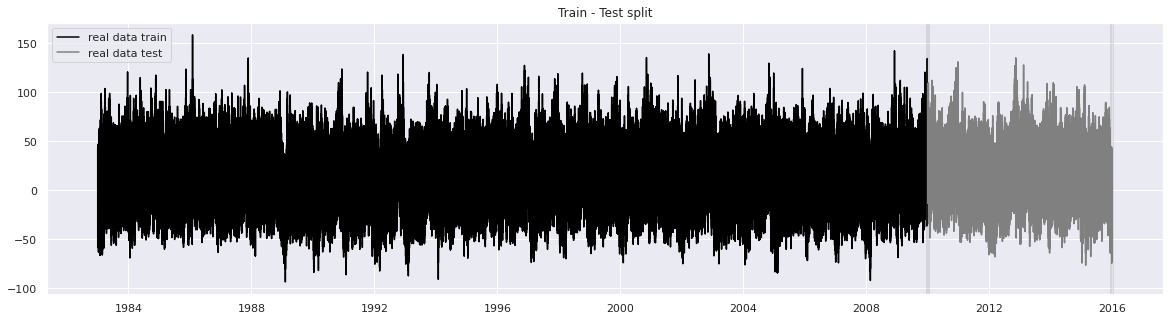

In [40]:
separating_date_1 = pd.to_datetime('20100101', format='%Y%m%d')
separating_date_2 = pd.to_datetime('20201201', format='%Y%m%d')
train_df = main_df.loc[main_df.index < separating_date_1]
test_df = main_df.loc[((main_df.index >= separating_date_1)&(main_df.index < separating_date_2))]


# Visualise train test split
plt.title('Train - Test split')
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
plt.axvline(separating_date_1, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()

# Prophet 5 - lunar, solar, sinking, rising influences

In [41]:
features = ['moon_phase', 'sun_acceleration']

train_prophet = train_df[[forecast_column]+features].reset_index()
train_prophet.columns = ['ds','y']+features
test_prophet = test_df[[forecast_column]+features].reset_index()
test_prophet.columns = ['ds','y']+features

# Prophet https://facebook.github.io/prophet/docs/
m_5 = Prophet(seasonality_mode='multiplicative', #seasonality_mode='multiplicative' or 'additive'
                interval_width=0.95, 
                daily_seasonality = False, 
                weekly_seasonality = False, 
                yearly_seasonality = False,
               )

# https://stackoverflow.com/questions/47534553/how-to-extract-seasonal-trends-from-prophet
m_5.add_seasonality(name='M2_lunar_principal_semidiurnal', period=(12.4206012/24), fourier_order=2)
m_5.add_seasonality(name='N2_lunar_elliptic_semidiurnal', period=(12.65834751/24), fourier_order=2)
m_5.add_seasonality(name='K1_lunar_diurnal', period=(23.93447213/24), fourier_order=2)
m_5.add_seasonality(name='O1_lunar_diurnal', period=(25.81933871/24), fourier_order=2)
m_5.add_seasonality(name='M4_lunar_overtides', period=(6.210300601/24), fourier_order=2)
m_5.add_seasonality(name='M6_lunar_overtides', period=(4.140200401/24), fourier_order=2)
m_5.add_regressor('moon_phase')

m_5.add_seasonality(name='S2_solar_principal_semidiurnal', period=(12/24), fourier_order=2)
m_5.add_seasonality(name='K2_lunisolar_semidiurnal', period=(11.96723606/24), fourier_order=2)
m_5.add_seasonality(name='P1_solar_diurnal', period=(24.06588766/24), fourier_order=2)
m_5.add_regressor('sun_acceleration')

m_5.fit(train_prophet)

In [42]:
forecast_train = prophet_predict_by_chunks(train_prophet, m_5)

Percent: [------------------->] 100%

In [43]:
forecast_train.to_csv('Data/Venezia/m5_forecast_train.csv')

In [44]:
# Predict over train data
"""
forecast_train = prophet_predict_by_chunks(train_prophet, m_5)
forecast_train.to_csv('Data/Venezia/m5_forecast_train.csv')
"""
forecast_train = pd.read_csv('Data/Venezia/m5_forecast_train.csv').drop('Unnamed: 0', axis=1)
forecast_train['ds'] = pd.to_datetime(forecast_train['ds'], errors='coerce')
forecast_train.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,K1_lunar_diurnal,K1_lunar_diurnal_lower,K1_lunar_diurnal_upper,K2_lunisolar_semidiurnal,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,sun_acceleration,sun_acceleration_lower,sun_acceleration_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1983-01-01 01:00:00,18.347445,21.776533,78.083003,18.347445,18.347445,0.394942,0.394942,0.394942,0.004452,...,1.794417,1.794417,1.794417,0.003637,0.003637,0.003637,0.0,0.0,0.0,51.270416
1,1983-01-01 02:00:00,18.347690,16.293269,69.628142,18.347690,18.347690,0.651788,0.651788,0.651788,0.059173,...,1.331068,1.331068,1.331068,0.003638,0.003638,0.003638,0.0,0.0,0.0,42.769720
2,1983-01-01 03:00:00,18.347936,1.104827,57.645001,18.347936,18.347936,0.851822,0.851822,0.851822,0.099001,...,0.654916,0.654916,0.654916,0.003638,0.003638,0.003638,0.0,0.0,0.0,30.364287
3,1983-01-01 04:00:00,18.348181,-9.043753,49.546203,18.348181,18.348181,0.973341,0.973341,0.973341,0.113302,...,-0.009953,-0.009953,-0.009953,0.003638,0.003638,0.003638,0.0,0.0,0.0,18.165569
4,1983-01-01 05:00:00,18.348427,-15.584649,39.455142,18.348427,18.348427,1.005450,1.005450,1.005450,0.097167,...,-0.456390,-0.456390,-0.456390,0.003638,0.003638,0.003638,0.0,0.0,0.0,9.974390


In [45]:
forecast_test = prophet_predict_by_chunks(test_prophet, m_5)

Percent: [------------------->] 100%

In [46]:
forecast_test.to_csv('Data/Venezia/m5_forecast_test.csv')

In [47]:
# Predict over validation data 
"""
forecast_test = prophet_predict_by_chunks(test_prophet, m_5)
forecast_test.to_csv('Data/Venezia/m5_forecast_test.csv')
"""
forecast_test = pd.read_csv('Data/Venezia/m5_forecast_test.csv').drop('Unnamed: 0', axis=1)
forecast_test['ds'] = pd.to_datetime(forecast_test['ds'], errors='coerce')
forecast_test.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,K1_lunar_diurnal,K1_lunar_diurnal_lower,K1_lunar_diurnal_upper,K2_lunisolar_semidiurnal,...,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,sun_acceleration,sun_acceleration_lower,sun_acceleration_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2010-01-01 00:00:00,20.135636,24.387627,82.589669,20.135636,20.135636,0.111623,0.111623,0.111623,-0.051294,...,1.639739,1.639739,1.639739,0.003630,0.003630,0.003630,0.0,0.0,0.0,53.152831
1,2010-01-01 01:00:00,20.135648,16.147167,75.013439,20.135648,20.135648,0.396350,0.396350,0.396350,0.004753,...,1.255615,1.255615,1.255615,0.003631,0.003631,0.003631,0.0,0.0,0.0,45.418266
2,2010-01-01 02:00:00,20.135660,3.973936,60.795625,20.135660,20.135660,0.652977,0.652977,0.652977,0.059429,...,0.638015,0.638015,0.638015,0.003631,0.003631,0.003631,0.0,0.0,0.0,32.982522
3,2010-01-01 03:00:00,20.135673,-9.668874,48.163472,20.135673,20.135673,0.852657,0.852657,0.852657,0.099149,...,0.000590,0.000590,0.000590,0.003631,0.003631,0.003631,0.0,0.0,0.0,20.147549
4,2010-01-01 04:00:00,20.135685,-19.217975,40.019837,20.135685,20.135685,0.973736,0.973736,0.973736,0.113297,...,-0.445503,-0.445503,-0.445503,0.003631,0.003631,0.003631,0.0,0.0,0.0,11.165173


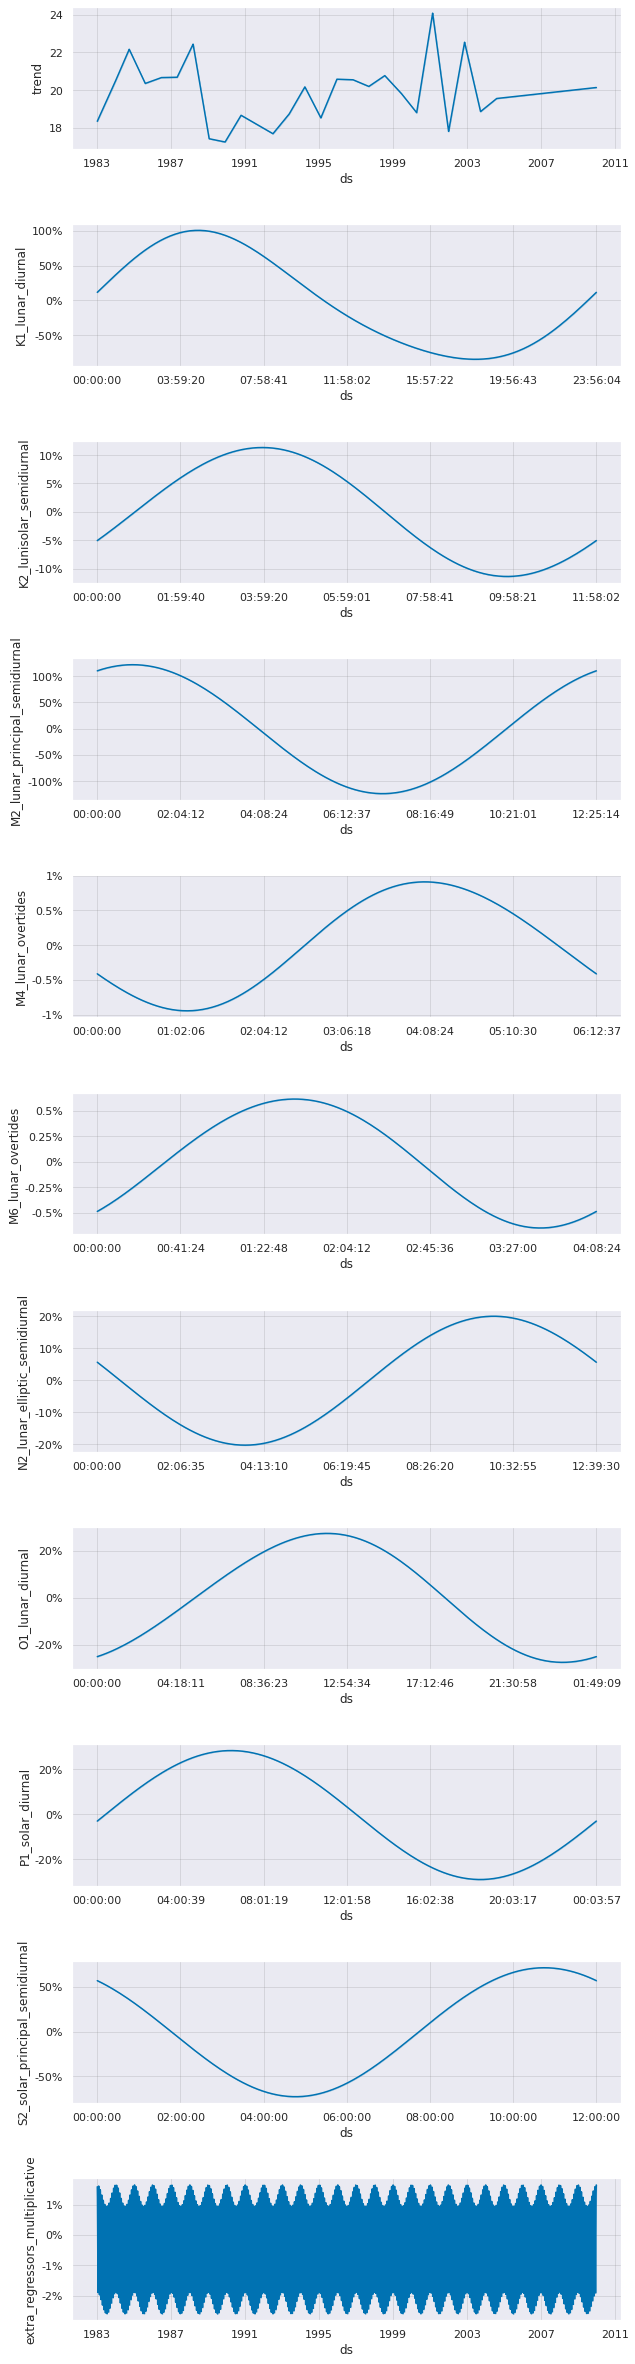

In [48]:
# Plot Prophet components
fig = m_5.plot_components(forecast_train)
plt.show()

In [49]:
y_train_pred = forecast_train[['ds','yhat']].set_index('ds',drop=True)
y_train_pred.index.name = None
y_train_pred = y_train_pred['yhat']

y_test_pred = forecast_test[['ds','yhat']].set_index('ds',drop=True)
y_test_pred.index.name = None
y_test_pred = y_test_pred['yhat']

y_all_pred = y_train_pred.append(y_test_pred)

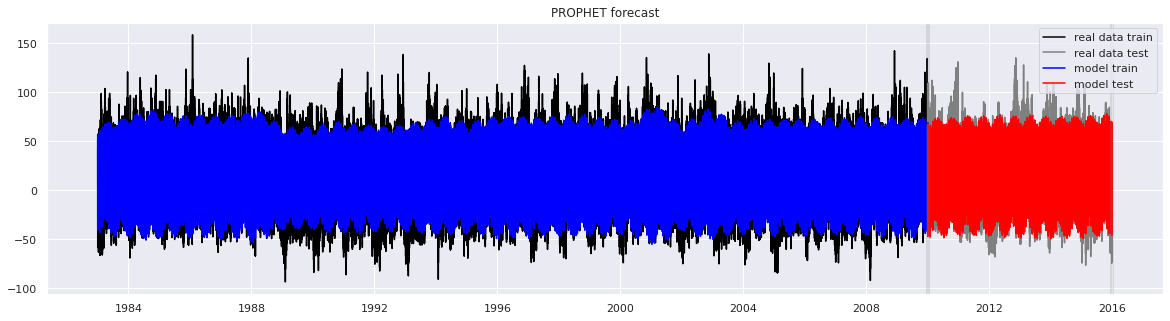

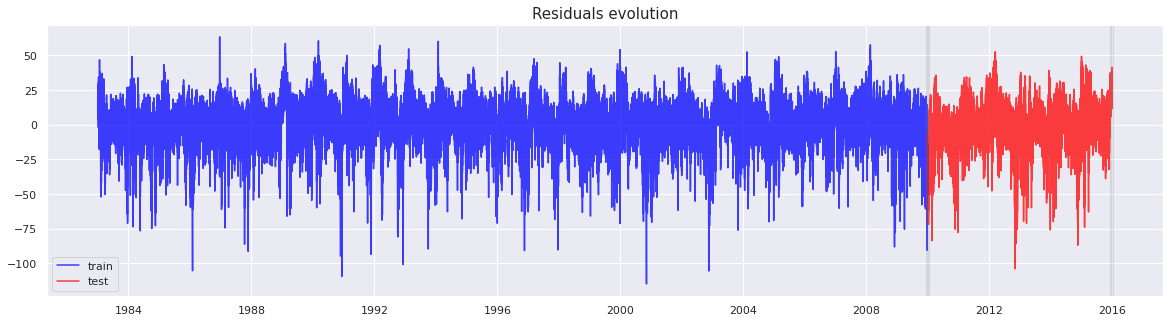

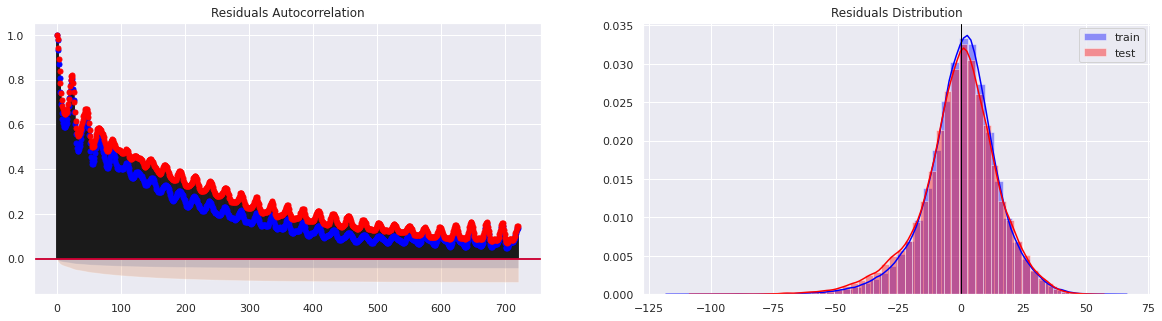

In [149]:
# PLOT

# Visualise forecast
plt.title('PROPHET forecast')
# Real data
plt.plot(train_df.index, train_df[forecast_column], color='black', label='real data train')
plt.plot(test_df.index, test_df[forecast_column], color='grey', label='real data test')
# Model
plt.plot(y_train_pred.index, y_train_pred, color='blue', label='model train')
plt.plot(y_test_pred.index, y_test_pred, color='red', label='model test')
# Test reference lines
plt.axvline(separating_date_1, color='grey', linewidth=4, alpha=.2)
plt.axvline(test_df.index[-1], color='grey', linewidth=4, alpha=.2)
plt.legend()
plt.show()


# Plot residuals
residuals_train = y_train_pred - train_df[forecast_column]
errors_test = y_test_pred - test_df[forecast_column]
residuales_totales = y_all_pred - main_df[forecast_column]
plot_residuals_distribution(residuales_totales, residuals_train, errors_test, 24*30)

In [53]:
test_df.head()

,datetime,level,moon_dist,sun_dist,moon_phase,sun_acceleration,Venice_relative_subsidence,CSIRO_adj_sea_level,adj_level
2010-01-01 00:00:00,2010-01-01 00:00:00,102.0,0.002402,0.983303,0.998003,6.124712e-23,2.701950,7.850000,91.448050
2010-01-01 01:00:00,2010-01-01 01:00:00,100.0,0.002402,0.983303,0.997716,6.124719e-23,2.701961,7.850091,89.447947
2010-01-01 02:00:00,2010-01-01 02:00:00,86.0,0.002401,0.983302,0.997410,6.124726e-23,2.701973,7.850183,75.447845
2010-01-01 03:00:00,2010-01-01 03:00:00,74.0,0.002401,0.983302,0.997084,6.124732e-23,2.701984,7.850274,63.447742
2010-01-01 04:00:00,2010-01-01 04:00:00,65.0,0.002401,0.983301,0.996740,6.124739e-23,2.701996,7.850365,54.447639


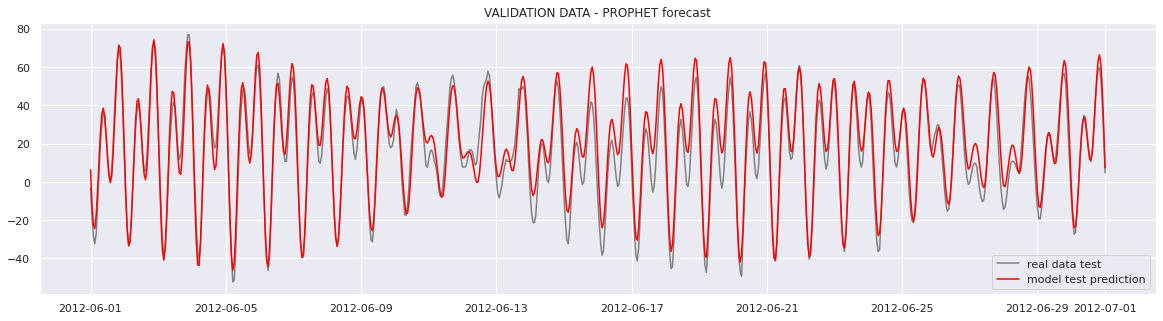

In [64]:
# Zoom in
date_i = pd.to_datetime('2012-06-01', format='%Y-%m-%d %H')
date_j = pd.to_datetime('2012-07-01', format='%Y-%m-%d %H')

plt.title('VALIDATION DATA - PROPHET forecast')
# Real data
plt.plot(test_df.index[((test_df['datetime']>=date_i)&(test_df['datetime']<=date_j))], test_df[forecast_column][((test_df['datetime']>=date_i)&(test_df['datetime']<=date_j))], color='grey', label='real data test')
# Model
plt.plot(y_test_pred.index[((test_df['datetime']>=date_i)&(test_df['datetime']<=date_j))], y_test_pred[((test_df['datetime']>=date_i)&(test_df['datetime']<=date_j))], color='red', label='model test prediction')
plt.legend()
plt.show()

In [52]:
evaluation = pd.DataFrame({'Metrics': ['MAPE', 'MSE', 'R2'],
                           'Train': [np.median(np.abs((train_df[forecast_column] - y_train_pred) / train_df[forecast_column])), 
                                     np.sqrt(((y_train_pred - train_df[forecast_column]) ** 2).mean()), 
                                     r2_score(train_df[forecast_column], y_train_pred)], 
                           'Test': [np.median(np.abs((test_df[forecast_column] - y_test_pred) / test_df[forecast_column])), 
                                     np.sqrt(((y_test_pred - test_df[forecast_column]) ** 2).mean()), 
                                     r2_score(test_df[forecast_column], y_test_pred)]
                          })

evaluation['Degradation (%)'] = round(100*(evaluation['Test']-evaluation['Train'])/evaluation['Train'],2)
evaluation

,Metrics,Train,Test,Degradation (%)
0,MAPE,0.345910,0.373695,8.03
1,MSE,14.617771,15.724518,7.57
2,R2,0.743677,0.687099,-7.61


# Time of next highest tide

In [132]:
def get_max_df(df, id_str):
    df.columns = ['ds', 'y']

    df.index = pd.DatetimeIndex(df['ds'])
    df.index.name = None

    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    df['week_of_year'] = df.index.weekofyear

    df_max = df.groupby(['year','week_of_year','month','day'])['y'].max().reset_index()
    df_max['max'] = 1

    df = pd.merge(df, df_max, how='left', 
                  on=['year','week_of_year','month','day','y'])
    df.fillna(0, inplace=True)
    
    df = df.loc[df['max']==1, ['y','year','week_of_year','month','day','hour']]
    df.columns = ['y'+id_str,'year','week_of_year','month','day','hour'+id_str]
    return df

In [133]:
y_pred_max = get_max_df(y_test_pred.reset_index(), '_pred')
display(y_pred_max.head())

y_real_max = get_max_df(test_df[forecast_column].reset_index(), '_real')
display(y_pred_max.head())

both = pd.merge(y_pred_max, y_real_max, how='left', on=['year','week_of_year','month','day'])
both.head()

,y_pred,year,week_of_year,month,day,hour_pred
10,67.610585,2010,53,1,1,10
35,64.566524,2010,53,1,2,11
49,59.317436,2010,53,1,3,1
73,59.137723,2010,1,1,4,1
98,59.016263,2010,1,1,5,2


,y_pred,year,week_of_year,month,day,hour_pred
10,67.610585,2010,53,1,1,10
35,64.566524,2010,53,1,2,11
49,59.317436,2010,53,1,3,1
73,59.137723,2010,1,1,4,1
98,59.016263,2010,1,1,5,2


,y_pred,year,week_of_year,month,day,hour_pred,y_real,hour_real
0,67.610585,2010,53,1,1,10,108.447023,10
1,64.566524,2010,53,1,2,11,96.445482,1
2,59.317436,2010,53,1,3,1,87.443016,1
3,59.137723,2010,1,1,4,1,79.439317,13
4,59.016263,2010,1,1,5,2,77.437879,3


In [101]:
both['hour_diff'] = both['hour_pred'] - both['hour_real']
both.head()

,y_pred,year,month,day,hour_pred,y_real,hour_real,hour_diff
0,67.610585,2010,1,1,10,108.447023,10,0
1,64.566524,2010,1,2,11,96.445482,1,10
2,59.317436,2010,1,3,1,87.443016,1,0
3,59.137723,2010,1,4,1,79.439317,13,-12
4,59.016263,2010,1,5,2,77.437879,3,-1


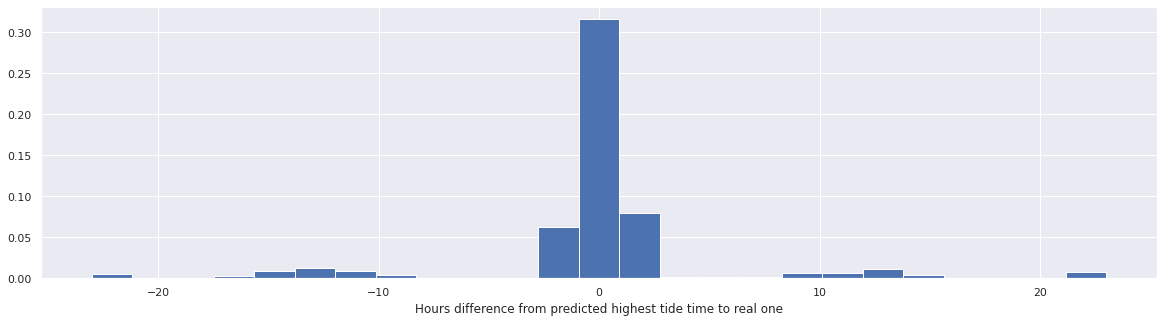

In [107]:
plt.hist(both['hour_diff'], bins=25, density = True)
plt.xlabel('Hours difference from predicted highest tide time to real one')
plt.show()

In [115]:
both['hour_diff'].quantile(0.085)

-1.0

In [118]:
both['hour_diff'].quantile(0.92)

2.0

In [135]:
display(both.head())
both_2 = both.groupby(['year','week_of_year'])['y_pred','y_real'].agg('max').reset_index()
both_2.head()

,y_pred,year,week_of_year,month,day,hour_pred,y_real,hour_real
0,67.610585,2010,53,1,1,10,108.447023,10
1,64.566524,2010,53,1,2,11,96.445482,1
2,59.317436,2010,53,1,3,1,87.443016,1
3,59.137723,2010,1,1,4,1,79.439317,13
4,59.016263,2010,1,1,5,2,77.437879,3


/home/alumno/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,year,week_of_year,y_pred,y_real
0,2010,1,59.137723,109.432845
1,2010,2,58.918784,84.420002
2,2010,3,55.465086,61.406029
3,2010,4,65.704755,75.375516
4,2010,5,66.123342,73.371509


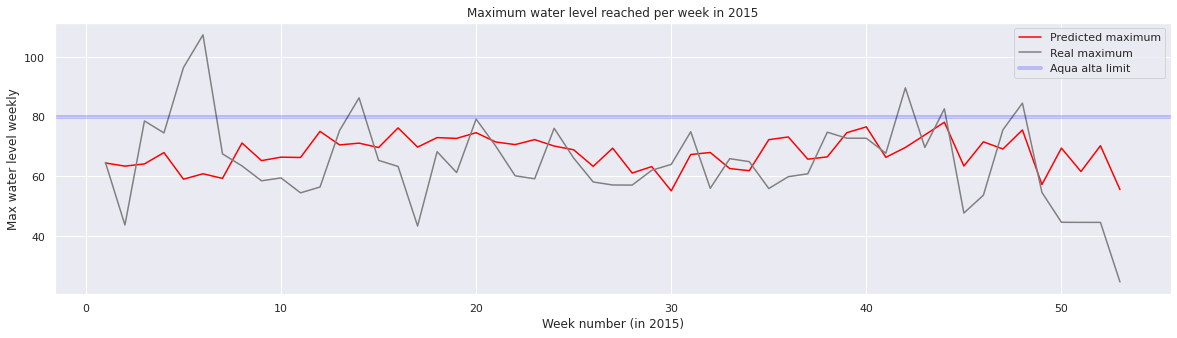

In [148]:
plt.plot(both_2.loc[both_2['year']==2015, 'week_of_year'], both_2.loc[both_2['year']==2015, 'y_pred'], color = 'red', label='Predicted maximum')
plt.plot(both_2.loc[both_2['year']==2015, 'week_of_year'], both_2.loc[both_2['year']==2015, 'y_real'], color = 'grey', label='Real maximum')
plt.ylabel('Max water level weekly')
plt.xlabel('Week number (in 2015)')
plt.axhline(80, color='blue', linewidth=4, alpha=.2, label='Aqua alta limit')
plt.title('Maximum water level reached per week in 2015')
plt.legend()
plt.show()